In [120]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform
from ott.geometry.costs import SqEuclidean

In [ ]:
def C1(T, q, mu, p_max): # upper bound
    t = T * q
    mu = np.minimum(mu, p_max) # scale to either remain the same or push to bound
    T = t * np.divide(mu[:,None], np.sum(t, axis=1, keepdims=True))
    q = np.divide(t, T)
    return T, q, mu

def C2(T, q, mu, p_min): # lower bound
    t = T * q
    mu = np.maximum(mu, p_min) # scale to either remain the same or push to bound
    T = t * np.divide(mu[:,None], np.sum(t, axis=1, keepdims=True))
    q = np.divide(t, T)
    return T, q, mu
    
def C0(T, q, mu): # row constraint
    t = T * q
    T = t * np.divide(mu[:,None], np.sum(t, axis=1, keepdims=True))
    q = np.divide(t, T)
    return T, q

def C3(T, q, nu): # column constraint
    t = T * q
    T = t * np.divide(nu[None,:], np.sum(t, axis=0, keepdims=True))
    q = np.divide(t, T)
    return T, q


In [122]:
N = 51
NUM_ITERS = 500

lmb = 1e-3

xa, xb = 0, 1
ya, yb = 0, 1

x = np.linspace(xa, xb, N)
y = np.linspace(ya, yb, N)

def mu(x):
    return norm.pdf(x, loc=(xa+xb)/2, scale=0.25) + 0.01

def nu(y):
    # return uniform.pdf(y, loc=ya, scale=yb)
    return norm.pdf(y, loc=0.2, scale=0.2) + norm.pdf(y, loc=0.35, scale=0.1)

m = mu(x)
m /= sum(m)

n = nu(y)
n /= sum(n)

def h(x, y):
    return np.exp(-(0.5 * (np.abs(x - y) ** 2)) / lmb) + 1e-200 # force all elements to be non-zero
K = h(x[:, None], y[None, :])


In [123]:
m_ub = m + (np.random.rand(N) - 0.5) * np.mean(m) * 0.5
m_lb = np.ones_like(m) * 0.0

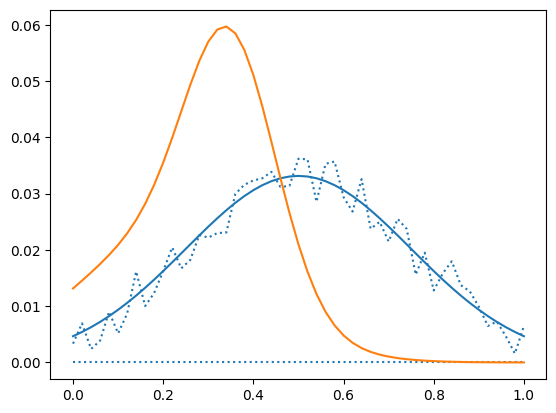

In [124]:
fig, ax = plt.subplots()

ax.plot(x, m, label='mu(x)', c='tab:blue')
ax.plot(x, m_ub, label=r'$\bar \mu(x)$', c='tab:blue', linestyle='dotted')
ax.plot(x, m_lb, label=r'$\_ \mu(x)$', c='tab:blue', linestyle='dotted')
ax.plot(y, n, label='nu(y)', c='tab:orange')

In [125]:
T.shape

(51, 51)

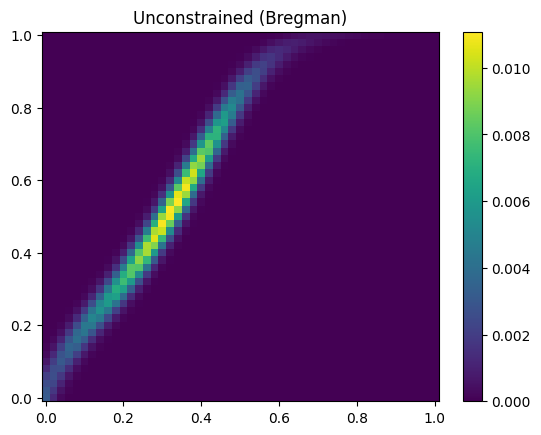

In [126]:
T = K.copy()
T_old = T.copy()
differ = np.zeros((NUM_ITERS,))

for i in range(NUM_ITERS):
    T *= np.divide(m[:,None], np.sum(T, axis=1, keepdims=True))
    T *= np.divide(n[None,:], np.sum(T, axis=0, keepdims=True))

    differ[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()

plt.pcolormesh(x, y, T, shading="auto")
plt.title('Unconstrained (Bregman)')
plt.colorbar()

Text(0.5, 1.0, 'Convergence of Unconstrained Bregman')

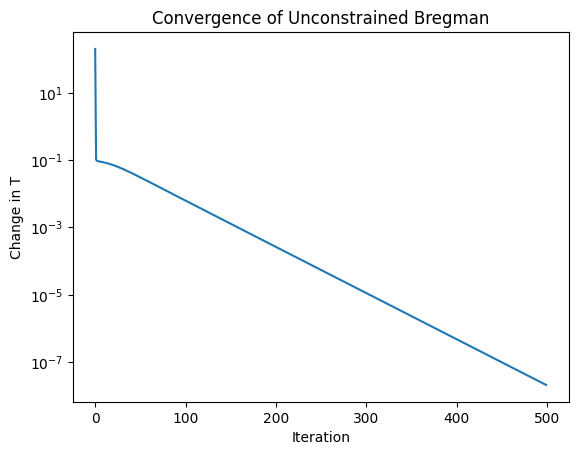

In [127]:
fig, ax = plt.subplots()

ax.plot(differ)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')
ax.set_title('Convergence of Unconstrained Bregman')

<BarContainer object of 51 artists>

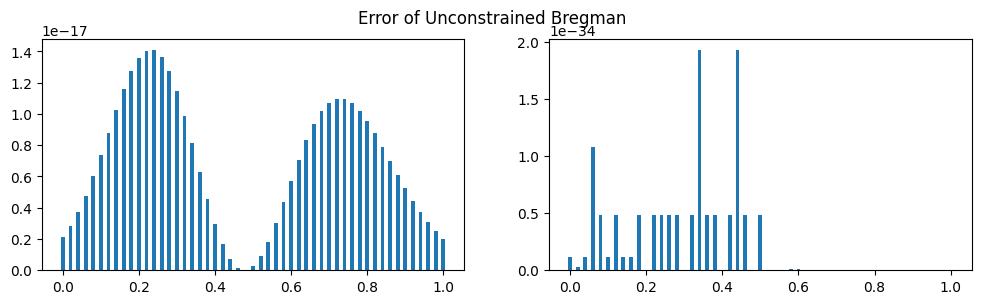

In [128]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
fig.suptitle('Error of Unconstrained Bregman')

axs[0].bar(x=x, height=(m - np.sum(T, axis=1))**2, width=0.01)
axs[1].bar(x=y, height=(n - np.sum(T, axis=0))**2, width=0.01)

## BOUNDED

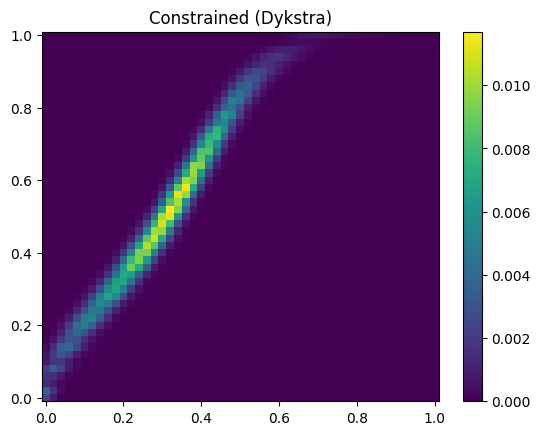

In [129]:
q1 = np.ones_like(K)
q2 = np.ones_like(K)
q3 = np.ones_like(K)
T = K.copy()
mu_new = m.copy()

T_old = T.copy()
differ = np.zeros((NUM_ITERS,))

for i in range(NUM_ITERS):
    T, q1, mu_new = C1(T, q1, mu_new, m_ub) # ub
    T, q2, mu_new = C2(T, q2, mu_new, m_lb) # lb
    T, q3 = C3(T, q3, n) # normal col constraint

    differ[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()

plt.pcolormesh(x, y, T, shading="auto")
plt.title('Constrained (Dykstra)')
plt.colorbar()

<BarContainer object of 51 artists>

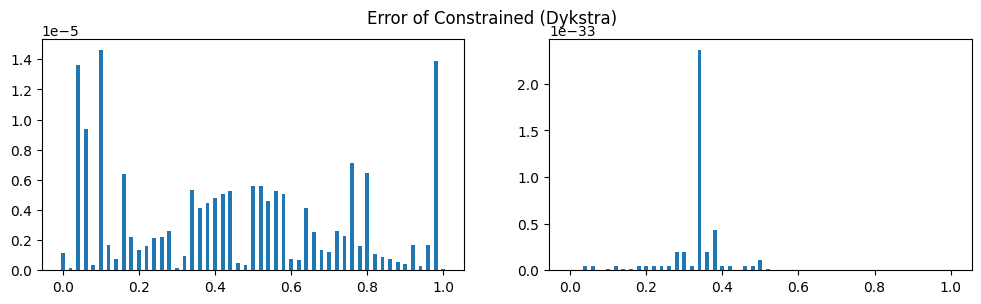

In [130]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
fig.suptitle('Error of Constrained (Dykstra)')

axs[0].bar(x=x, height=(m - np.sum(T, axis=1))**2, width=0.01)
axs[1].bar(x=y, height=(n - np.sum(T, axis=0))**2, width=0.01)

Text(0.5, 1.0, 'Convergence of Constrained (Dykstra)')

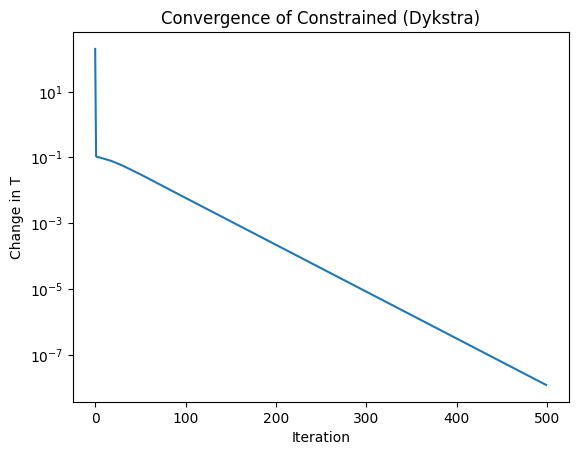

In [131]:
fig, ax = plt.subplots()

ax.plot(differ)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')
ax.set_title('Convergence of Constrained (Dykstra)')

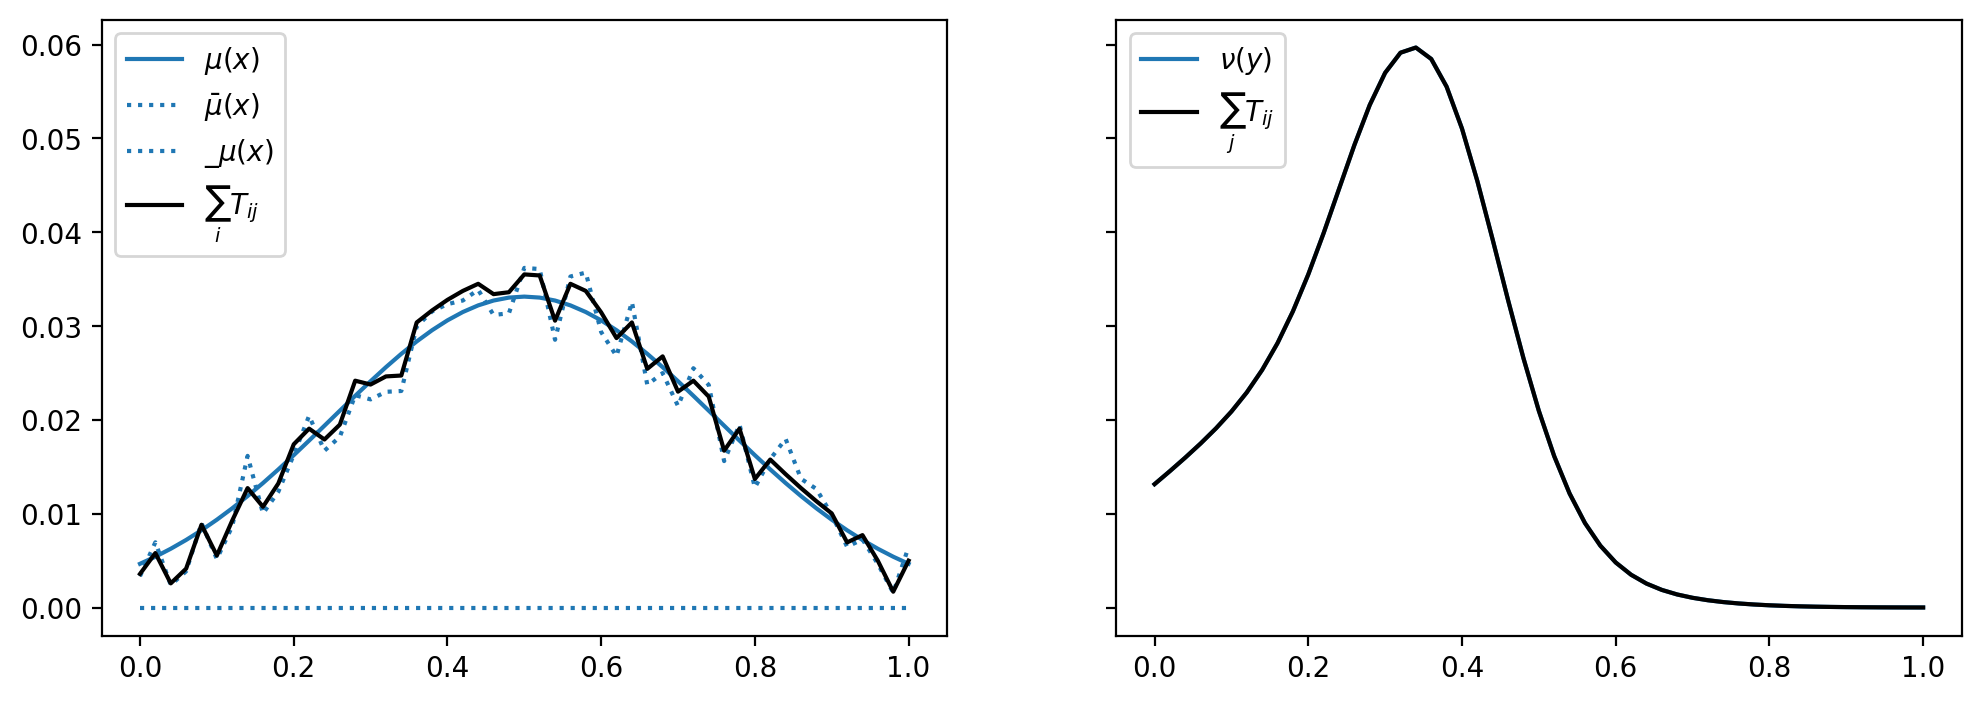

In [132]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True, dpi=200)

axs[0].plot(x, m, label=r'$\mu(x)$', c='tab:blue')
axs[0].plot(x, m_ub, label=r'$\bar \mu(x)$', c='tab:blue', linestyle='dotted')
axs[0].plot(x, m_lb, label=r'$\_ \mu(x)$', c='tab:blue', linestyle='dotted')
axs[0].plot(x, np.sum(T, axis=1), c='k', label=r'$\sum_i T_{ij}$')
axs[0].legend(loc='upper left')

axs[1].plot(y, n, label=r'$\nu(y)$', c='tab:blue')
axs[1].plot(y, np.sum(T, axis=0), c='k', label=r'$\sum_j T_{ij}$')
axs[1].legend(loc='upper left')